In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# Set seaborn style for better visuals
sns.set(style="whitegrid")


In [2]:
# Importing the Required Packages

import numpy as np
import pandas as pd
import os
from pathlib import Path

# NLTK Packages for NLP Tasks
import string
import nltk
from nltk.corpus import stopwords

# Scikitlearn functions imported for doing evaluation of model and also analyse the dataset
import scipy.io
import scipy.linalg
from scipy.sparse import csr_matrix, vstack, lil_matrix
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Loading the ML Models used to classify the data into hate, offensive and neither category
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Packages for visualization
import plotly.express as px
import plotly.figure_factory as ff
from yellowbrick.text import TSNEVisualizer

In [5]:
# Downloading the necessary packages from NLTK library
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Function to load the dataset and return the Data frame
def load_data(path):
    df = pd.read_csv(path, index_col=0)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [9]:
# We load the data and print the 1st 10 entries from the Dataframe.
path = "/content/drive/MyDrive/Disseration UON/Datasets/labeled_data.csv"
tdf = load_data(path)
tdf.head(10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,3,0,1,RT @sonup_qp: Llamf cumin wit better bars alre...
1,3,0,0,3,2,#BlessJesus Amos 5:10 There are those who hate...
2,3,1,2,0,1,RT @ibethathigh_RNS: She called me Mexican is ...
3,6,0,0,6,2,such a sucker for some Oreos
4,4,3,1,0,0,&#8220;@AlexaDelsanter: This is awkward u fag ...
5,3,0,3,0,1,"RT @yNeverEleven: @VernNotice ""you don't want ..."
6,3,1,2,0,1,@YunGMiGo @BigMoneyNiquee &#128530; nicca fucc yu
7,3,1,2,0,1,"A big ass wasp was flying round on my bus, my ..."
8,3,0,2,1,1,Throw a rager on your sweet 16 and everybody b...
9,3,0,3,0,1,one good girl is worth 1000 bitches


In [10]:


# Remove stop words, special chars
# stem the word tokens
# re.sub(r'^https?:\/\/.*[\r\n]*', '', text)

# The function is used to clean the tweet, i.e, to remove the special characters and the stop words.
def Tweet_Cleaning(sent):
    stemmer = nltk.PorterStemmer()
    tknzr = nltk.RegexpTokenizer(r'[a-zA-Z0-9]+')

    exclp = list(string.punctuation)
    exclc = [
        "'re", "n't", "'m", "'s", "n't", "'s",
        "``", "''", "'ve", "'m", "'ll", "'ve",
        "...", "http", "https"]
    sw = set(stopwords.words("english") + exclp + exclc)

    tokens = tknzr.tokenize(sent.lower())
    words = [stemmer.stem(token) for token in tokens if not token in sw]
    return " ".join(words)


    # Function to clean the tweet and update the dataframe with the cleaned version of the tweet
def Tweet_Cleaning_DF(df):
    df["tweet"] = df["tweet"].apply(lambda t: Tweet_Cleaning(t))
    return df


    # Printing the data frame after doing the tweet-cleaning
tdf = Tweet_Cleaning_DF(tdf)
tdf.head(10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,3,0,1,rt sonup qp llamf cumin wit better bar alreadi...
1,3,0,0,3,2,blessjesu amo 5 10 hate one uphold justic cour...
2,3,1,2,0,1,rt ibethathigh rn call mexican tho im proud hi...
3,6,0,0,6,2,sucker oreo
4,4,3,1,0,0,8220 alexadelsant awkward u fag corleyhuff vit...
5,3,0,3,0,1,rt ynevereleven vernnotic want play cs go bitc...
6,3,1,2,0,1,yungmigo bigmoneynique 128530 nicca fucc yu
7,3,1,2,0,1,big ass wasp fli round bu dike bu driver stop ...
8,3,0,2,1,1,throw rager sweet 16 everybodi bring present c...
9,3,0,3,0,1,one good girl worth 1000 bitch


In [11]:
# Define the class mapping
class_mapping = {
    0: "Class - 0 (Neither Hate Speech nor Offensive)",
    1: "Class - 1 (Offensive)",
    2: "Class - 2 (Hate)"
}

# Map the class labels in the dataset
tdf['class_mapped'] = tdf['class'].map(class_mapping)

# Check if the mapping works by printing the first few rows
tdf[['class', 'class_mapped']].head()


,class,class_mapped
0,1,Class - 1 (Offensive)
1,2,Class - 2 (Hate)
2,1,Class - 1 (Offensive)
3,2,Class - 2 (Hate)
4,0,Class - 0 (Neither Hate Speech nor Offensive)


<ipython-input-12-a054d8d5c549>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class_mapped', data=tdf, palette='Set2')


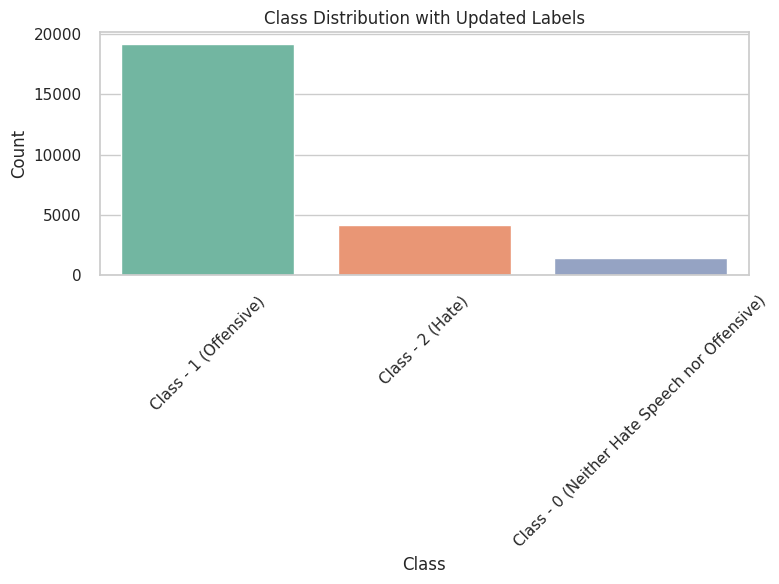

In [12]:
# Analyze Target Distribution
# Plot the target distribution
plt.figure(figsize=(8,6))
sns.countplot(x='class_mapped', data=tdf, palette='Set2')
plt.title('Class Distribution with Updated Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


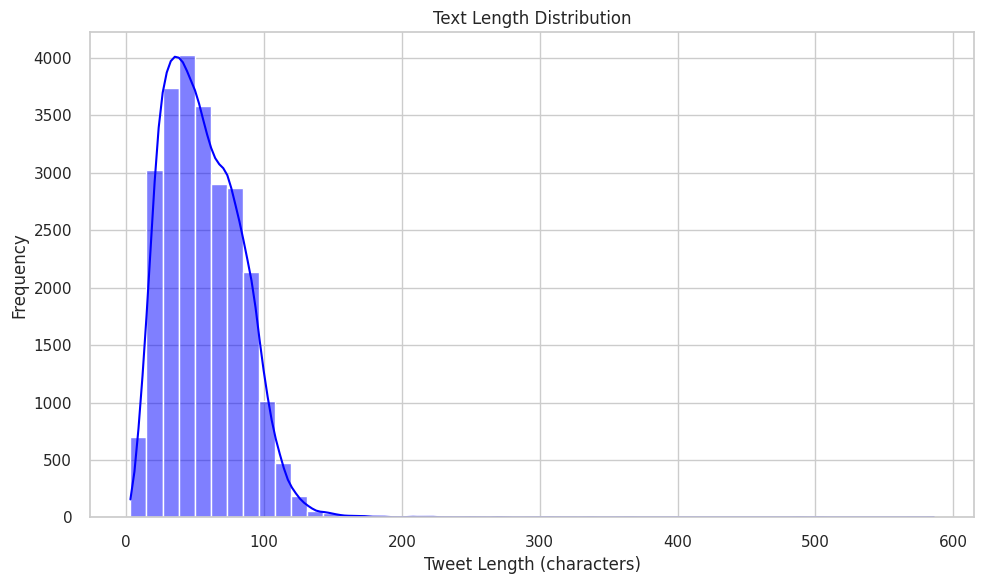

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a column for the length of each tweet
tdf['text_length'] = tdf['tweet'].apply(lambda x: len(x))

# Ploting the text length distribution
plt.figure(figsize=(10,6))
sns.histplot(tdf['text_length'], bins=50, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


<ipython-input-22-199f7dafe7bd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class_mapped', y='text_length', data=tdf, palette='Set2')


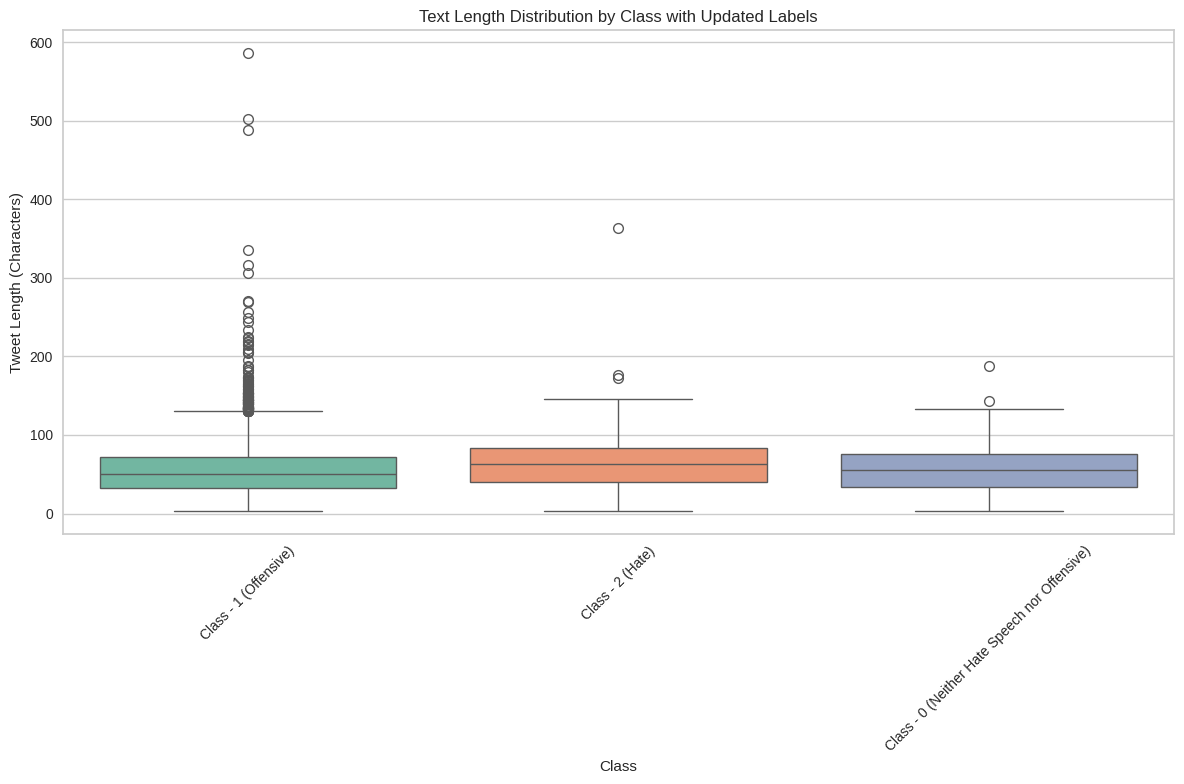

In [ ]:
# Create a column for the length of each tweet
tdf['text_length'] = tdf['tweet'].apply(lambda x: len(x))

# Ploting the text length distribution by class
plt.figure(figsize=(12,8))
sns.boxplot(x='class_mapped', y='text_length', data=tdf, palette='Set2')
plt.title('Text Length Distribution by Class with Updated Labels')
plt.xlabel('Class')
plt.ylabel('Tweet Length (Characters)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
pip install wordcloud


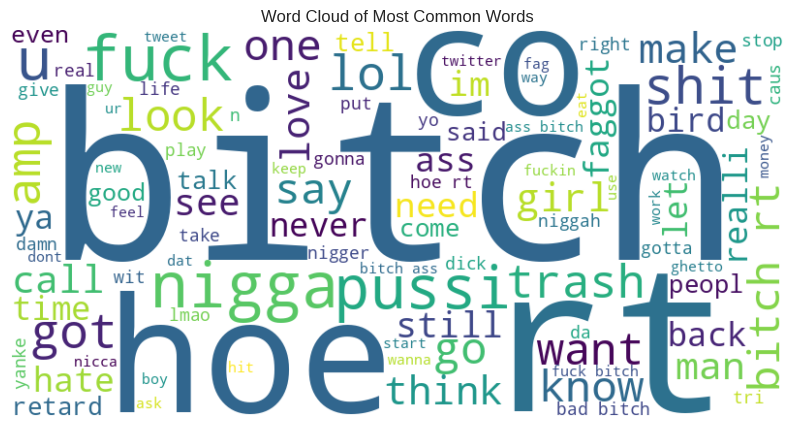

In [ ]:
from wordcloud import WordCloud

# Join all tweets to create a single string
all_words = ' '.join([text for text in tdf['tweet']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

# Ploting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Most Common Words')
plt.axis('off')
plt.show()


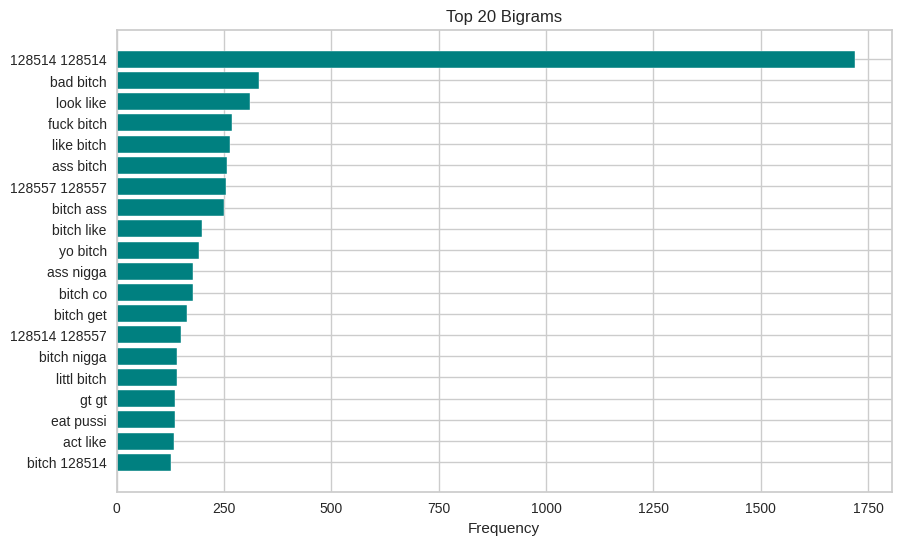

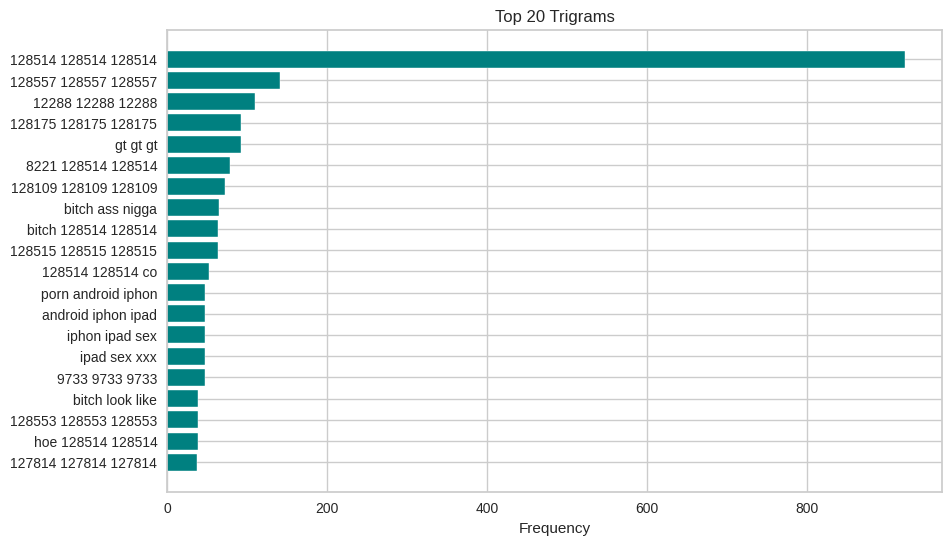

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Function to generate n-grams (bigrams and trigrams)
def plot_top_ngrams(text, n=2, top_n=20, title="Top Bigrams/Trigrams"):
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(text)
    bow = vectorizer.transform(text)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:top_n]

    # Plot
    words = [w[0] for w in words_freq]
    counts = [w[1] for w in words_freq]

    plt.figure(figsize=(10,6))
    plt.barh(words, counts, color='teal')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()  # Invert y-axis to show the top word at the top
    plt.show()

# Plot top 20 bigrams
plot_top_ngrams(tdf['tweet'], n=2, top_n=20, title="Top 20 Bigrams")

# Plot top 20 trigrams
plot_top_ngrams(tdf['tweet'], n=3, top_n=20, title="Top 20 Trigrams")
